#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

### Описание данных
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
import lightgbm
from catboost import CatBoostRegressor

from statsmodels.graphics import tsaplots
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#прочитаем файл, изменим тип данных, установим индекс таблицы равный Datetime
data.sort_index(inplace=True)#отсортируем индекс таблицы
print(data.index.is_monotonic)#проверим на хронологичность порядка даты и время
print(data.head())#выведим 5 строк
data.info()#изучим информацию

True
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Мы отсортировали индексы, хронологический порядок соблюден. Выполним ресемплирование по интервалу за 1 день и за 1 час.

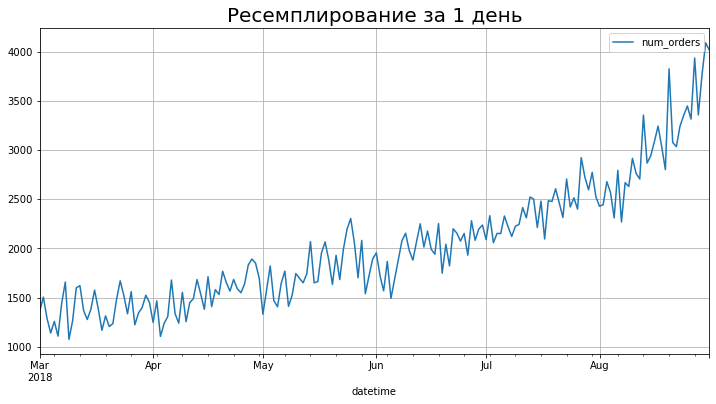

In [3]:
data_D = data['2018-03':'2018-08'].resample('1D').sum()#построим график заказов такси в данный период, выберим интервал в один день
data_D.plot(grid=True, figsize=(12,6))
plt.title('Ресемплирование за 1 день', fontsize = 20);#суммарное потребление

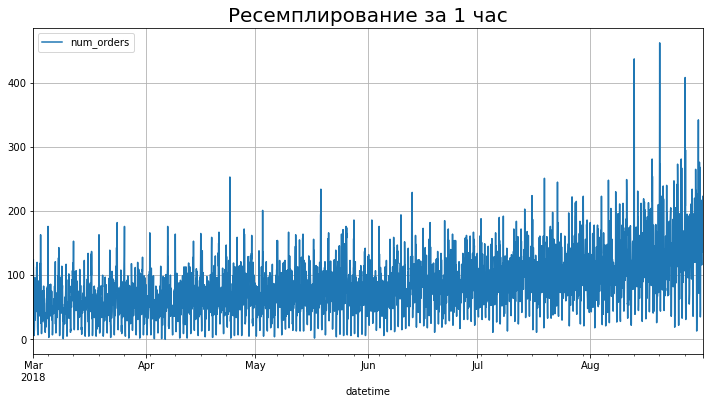

In [4]:
data = data['2018-03':'2018-08'].resample('1H').sum()#выполним ресемплирование по одному часу
data.plot(grid=True, figsize=(12,6))#суммарное потребление
plt.title('Ресемплирование за 1 час', fontsize = 20);

Мы видим что бывает и нулевой заказ такси по часам, но по дням такого не бывает, каждый день с нарастанием к концу августа количество вызовов увеличивается. Ускорение началось в большей мере с начала июня и возрастало скачкообразно,увеличиваясь до конца августа. 

## Анализ

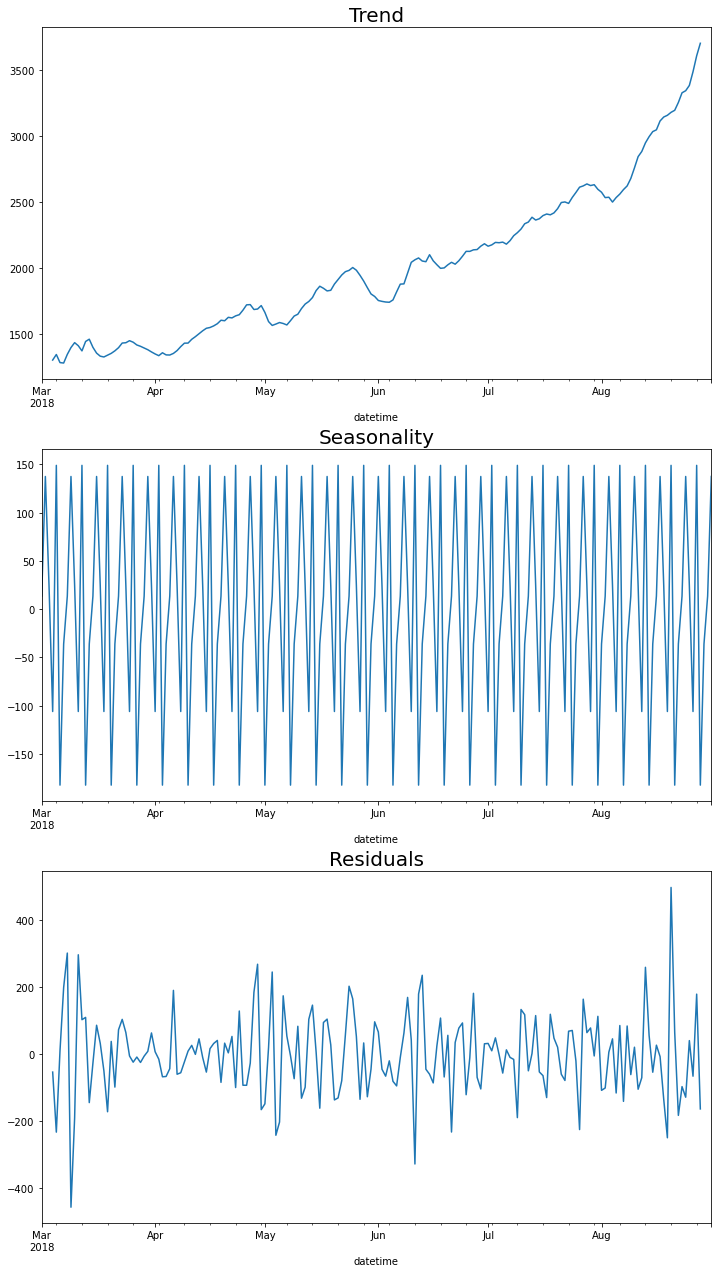

In [5]:
decomposed = seasonal_decompose(data_D)#разложим временной ряд на три состава
plt.figure(figsize=(12, 22))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', fontsize = 20)#тренд
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontsize = 20)#сезонная составляющая
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals', fontsize = 20);#остаток

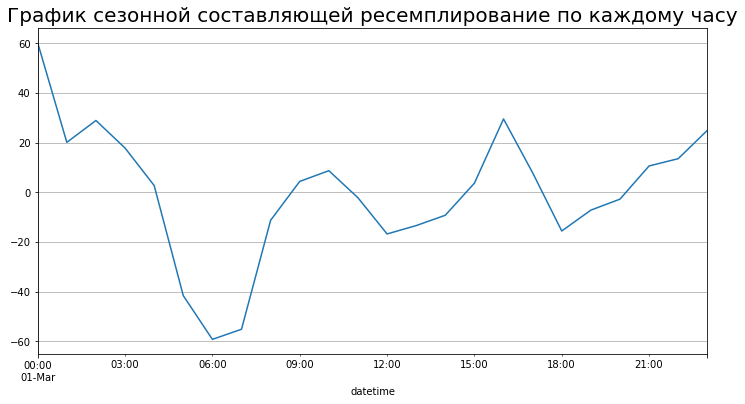

In [6]:
#построим график сезонной составляющей за 1 день ресемплирование по каждому часу
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-1'].plot(grid=True, figsize=(12,6))
plt.title('График сезонной составляющей pесемплирование по каждому часу', fontsize = 20);

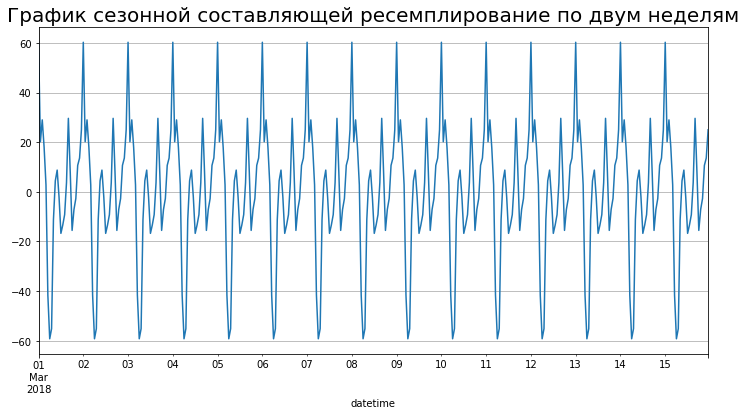

In [7]:
#построим график сезонной составляющей за 1 день ресемплирование по 2 неделям
data_W = data['2018-03':'2018-08'].resample('2W').sum()#выполним ресемплирование по двум неделям
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(grid=True, figsize=(12,6))
plt.title('График сезонной составляющей pесемплирование по двум неделям', fontsize = 20);

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


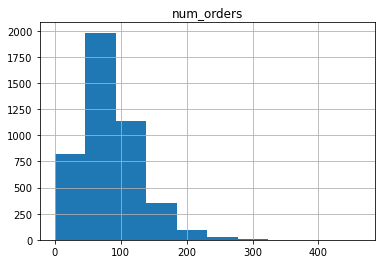

In [8]:
itog = data.describe()
data.hist()
itog

Мы исследовали данные на сезонность.  На графике в тренде, который связан со временем года, вызовов такси весной и летом выше, по сравнению с зимой. По графику сезонности мы заметили что есть недельная зависимость, так как каждую неделю скачкообразно меняется положение вызовов такси. Остатки более менее равномерны, хотя и имеют выбросы в марте, мае, июне и августе в определенные недели месяца, на качество модели они безусловно повлияют, но их доля не серьезна. График имеет выраженный тренд и не имеет яркиx выбросов из этого можно сделать вывод, что ряд не является стационарным. Ряд более менее однородный и имеет небольшой разброс. Для признаков возьмем месяц, неделю, часю

## Обучение

### Подготовка признаков для обучения

In [9]:
def make_features(data, max_lag, rolling_mean_size):#напишем функцию чтобы прибавить два признака день и час
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag+1):#напишем функцию и добавим аргумент max_lag который задаст максимум размер отставания
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 24, 48)#применим функцию к датасету
data = data.dropna()#заполним пропуски
data.head(10)


,num_orders,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,0,5,72.0,59.791667,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0
2018-03-03 01:00:00,108,3,1,5,163.0,60.604167,72.0,119.0,101.0,93.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0
2018-03-03 02:00:00,25,3,2,5,108.0,61.083333,163.0,72.0,119.0,101.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0
2018-03-03 03:00:00,64,3,3,5,25.0,60.125000,108.0,163.0,72.0,119.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0
2018-03-03 04:00:00,44,3,4,5,64.0,60.083333,25.0,108.0,163.0,72.0,...,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0
2018-03-03 05:00:00,15,3,5,5,44.0,60.104167,64.0,25.0,108.0,163.0,...,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0
2018-03-03 06:00:00,9,3,6,5,15.0,60.291667,44.0,64.0,25.0,108.0,...,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0
2018-03-03 07:00:00,17,3,7,5,9.0,60.229167,15.0,44.0,64.0,25.0,...,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0
2018-03-03 08:00:00,56,3,8,5,17.0,60.270833,9.0,15.0,44.0,64.0,...,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0


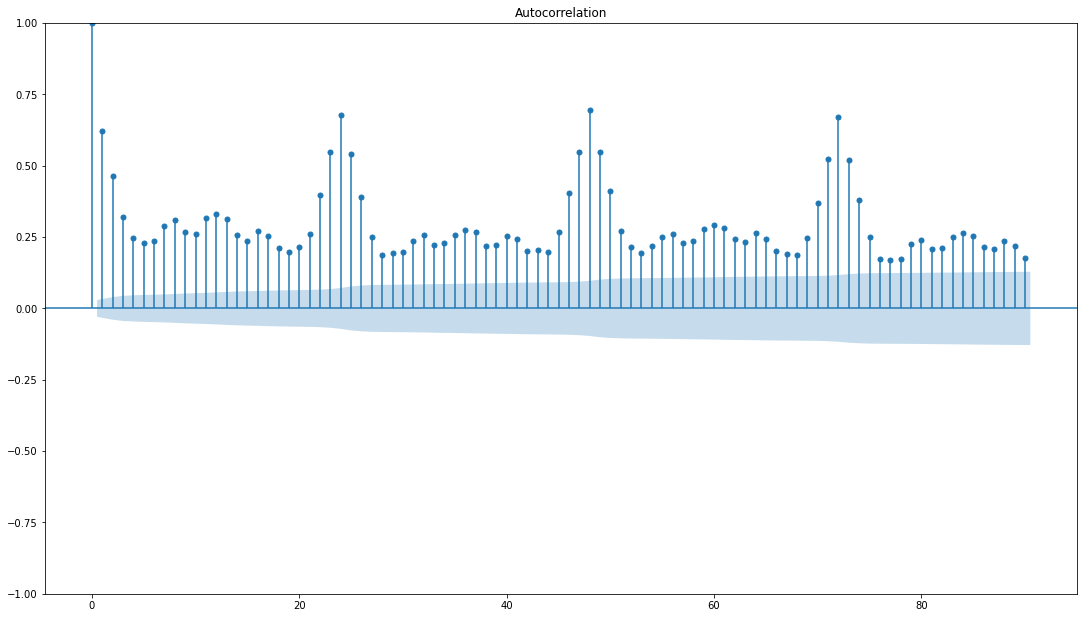

In [10]:
fig = tsaplots.plot_acf(data['num_orders'],lags= 90)
fig.set_size_inches(18.5, 10.5)
plt.show() 

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)#выделим для тестовой выборке 10%
print(train.index.min(), train.index.max())#посмотрим сколько минимальных и максимальных значений индексов выборок
print(test.index.min(), test.index.max())

2018-03-03 00:00:00 2018-08-13 18:00:00
2018-08-13 19:00:00 2018-08-31 23:00:00


In [13]:
train = train.dropna()
print(train.shape)
print(test.shape)

(3931, 29)
(437, 29)


In [14]:
features_train = train.drop(['num_orders'], axis=1) #выделим признаки
target_train = train['num_orders'] #выделим целевой признак

features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders']

### Модели для обучения

In [15]:
pipeline = Pipeline(
 [
 ('selector', SelectKBest(f_regression)),
 ('model', LinearRegression())
 ]
)
search = GridSearchCV(
 estimator = pipeline,
 param_grid = {'selector__k':[3,4,5,6,7,8,9,10]},
 n_jobs=-1,
 scoring="neg_root_mean_squared_error",
 cv=TimeSeriesSplit(n_splits=24),
 verbose=3
)
search.fit(features_train, target_train)

print('RMSE на обучающей выборке:', search.best_score_)

Fitting 24 folds for each of 8 candidates, totalling 192 fits
RMSE на обучающей выборке: -26.42015568162832


In [16]:
model_D = DecisionTreeRegressor(random_state=10)
model_D = GridSearchCV(model_D, param_grid={'max_depth': range(1, 5)}, cv=TimeSeriesSplit(n_splits=24),
                       scoring="neg_root_mean_squared_error", n_jobs=-1)
model_D.fit(features_train, target_train)

print('RMSE на обучающей выборке DecisionTreeRegressor:', model_D.best_score_)

RMSE на обучающей выборке DecisionTreeRegressor: -28.170190237438277


In [17]:
model_cat = CatBoostRegressor(silent=True)

param_cv = [{
'learning_rate': [0.05, 0.1],
'n_estimators': range(100, 500, 100),
'random_state': [123]
}]
model_cat_cv = GridSearchCV(model_cat, param_grid = param_cv, scoring ='neg_root_mean_squared_error',
                            cv=TimeSeriesSplit(n_splits=24))
model_cat_cv.fit(features_train, target_train)

print('RMSE на обучающей выборке CatBoostRegressor:', model_cat_cv.best_score_)

RMSE на обучающей выборке CatBoostRegressor: -22.608946267403507


In [18]:
model_light = LGBMRegressor()
parametrs_lght = [{'num_leaves': [4, 80, 100], 'learning_rate': [0.1, 0.3, 0.5], 'random_state': [123]}]

model_light = GridSearchCV(model_light, parametrs_lght, scoring = 'neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=24)) 
model_light.fit(features_train, target_train)

print('RMSE на обучающей выборке LGBMRegressor:', model_light.best_score_)

RMSE на обучающей выборке LGBMRegressor: -23.286552054436157


Самое низкое RMSE на тренировочной выборке получилось по градиентному бустингу библиотеки CatBoost 22.6. Применим эту модель на тестовой выборке.

## Тестирование

In [19]:
predict_cat = model_cat_cv.predict(features_test)
rmse_cat_test = mean_squared_error(target_test, predict_cat, squared=False)
print('RMSE на тестовой выборке CatBoostRegressor:', rmse_cat_test)

RMSE на тестовой выборке CatBoostRegressor: 41.80240615954552


__Вывод:___ Мы изучили исторические данные о заказах такси в аэропортах. Мы сделали ресемплирование по одному часу и проанализировали данные, взяв признаки за день и за час, обучили разные модели с различными гиперпараметрами. Мы спрогнозировали количество заказов такси на следующий час с минимальным значением RMSE на тестовой выборке 41.8 модели градиентоного бустинга библотеки CatBoost.  